In [1]:
from dataclasses import asdict
import math
import random
import itertools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from minitorch.module import LinearScalarLayer, LinearTensorLayer, ScalarNetwork, TensorNetwork
from minitorch.autodiff import Scalar
import minitorch.autodiff.tensor_functions as tf
from minitorch.optim import SGDOptimizer
from minitorch.datasets import Datasets, DatasetTypes
from minitorch.operators import sigmoid
import minitorch.scalar_metrics as sm
import minitorch.scalar_losses as sl
import minitorch.tensor_losses as tl
import minitorch.tensor_metrics as tm

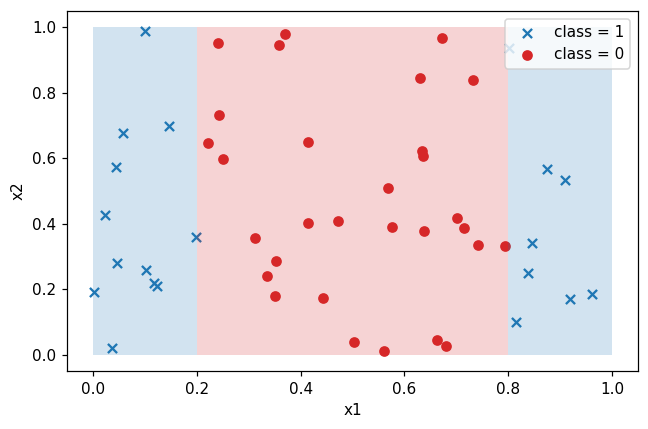

In [2]:
# Create a dataset
N_SAMPLES = 50
dataset_type = DatasetTypes.split

datasets = Datasets.generate_datasets(n_samples=N_SAMPLES)
dataset = asdict(datasets)[dataset_type]

pos_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 1]
neg_class = [x for (x, y) in zip(dataset.xs, dataset.ys) if y == 0]

x1_pos, x2_pos = zip(*pos_class)
x1_neg, x2_neg = zip(*neg_class)

fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue", label="class = 1")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red", label="class = 0")
ax.legend(loc=1)

left = Rectangle((0.0, 0.0), 0.2, 1.0, color="tab:blue", alpha=0.2, lw=0.0)
center = Rectangle((0.2, 0.0), 0.6, 1.0, color="tab:red", alpha=0.2, lw=0.0)
right = Rectangle((0.8, 0.0), 0.2, 1.0, color="tab:blue", alpha=0.2, lw=0.0)

ax.add_patch(left)
ax.add_patch(center)
ax.add_patch(right)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();

### Scalars

In [4]:
# Create a network
network = ScalarNetwork(input_dim=2, hidden_dim=10, output_dim=1)

# Define an optimizer
optimizer = SGDOptimizer(parameters=network.parameters(), lr=0.3)

# Data
X = [list(x) for x in dataset.xs]
y_true = dataset.ys

In [5]:
# Training loop
n_epochs = 150
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = network.forward(X)

    # Convert to binary class probabilties
    y_hat = [[scalar.sigmoid() for scalar in row] for row in y_hat]
    y_hat = list(itertools.chain.from_iterable(y_hat))
    
    # Compute a loss
    loss_per_epoch = sl.binary_cross_entropy(y_true, y_hat)
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.data)
    if epoch % 10 == 0:
        print(f"epoch {epoch}: loss = {loss_per_epoch.data}")

epoch 0: loss = 1.2366267235260124
epoch 10: loss = 0.712147780143426
epoch 20: loss = 0.6932127320389165


KeyboardInterrupt: 

In [6]:
# Metrics
y_true = [Scalar(y_t) for y_t in y_true]
y_hat = [[scalar.sigmoid() for scalar in row] for row in network.forward(X)]
y_hat = list(itertools.chain.from_iterable(y_hat))

# Convert to classes using 0.5 threshold
y_hat_classes = [Scalar(1.0) if proba.data >= 0.5 else Scalar(0.0) for proba in y_hat]

{
    f.__name__: f(y_true=y_true, y_hat=y_hat_classes)
    for f in [sm.accuracy, sm.precision, sm.recall]
}

{'accuracy': Scalar(0.600, name=Scalar369817),
 'precision': Scalar(0.000, name=Scalar370068),
 'recall': Scalar(0.000, name=Scalar370319)}

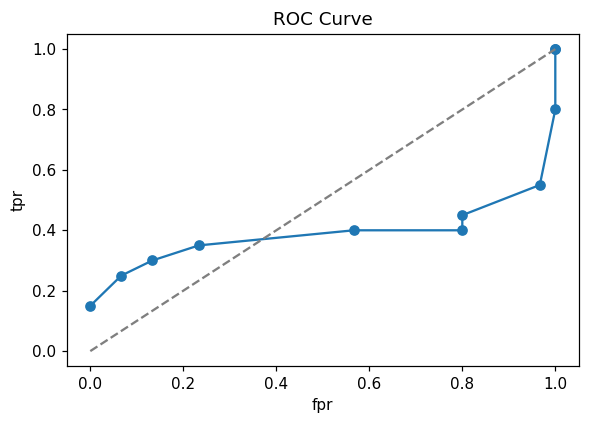

In [7]:
# ROC Curve
tpr, fpr, thresholds = sm.roc_curve(y_true, y_hat, bucket_size=0.01)
tpr, fpr = [s.data for s in tpr], [s.data for s in fpr]

fig, ax = plt.subplots(1, 1, dpi=110)
ax.plot(fpr, tpr, "-o", c="tab:blue")
ax.plot([0, 1], [0, 1], ls="--", c="tab:grey")
ax.set_xlabel("fpr")
ax.set_ylabel("tpr")
ax.set_title("ROC Curve");

In [ ]:
# Visualising predictions

# Plot original data
fig, ax = plt.subplots(1, 1, dpi=110)
ax.scatter(list(x1_pos), list(x2_pos), marker="x", c="tab:blue")
ax.scatter(list(x1_neg), list(x2_neg), marker="o", c="tab:red")

# Visualise decision boundaries

x1_positions = list(np.linspace(0, 1, 101))
x2_positions = list(np.linspace(0, 1, 101))

for x1_lower, x1_upper in zip(x1_positions, x1_positions[1:]):
    
    # Create corresponding x2 values
    X_lower = [list((x1_lower, x2)) for x2 in x2_positions]
    X_upper = [list((x1_upper, x2)) for x2 in x2_positions]
    
    # Get predictions
    y_lower = network.forward(X_lower)
    y_mean_lower = sigmoid(sum(scalar[0].data for scalar in y_lower) / len(y_lower))

    y_upper = network.forward(X_upper)
    y_mean_upper = sigmoid(sum(scalar[0].data for scalar in y_upper) / len(y_upper))

    # Plot and fill    
    ax.fill_betweenx(
        x2_positions,
        [x1_upper for _ in x2_positions],
        x1_lower,
        alpha=(y_mean_lower - 0.5) if y_mean_lower >= 0.5 else (0.5 - y_mean_lower),
        color="tab:blue" if y_mean_lower >= 0.5 else "tab:red",
        lw=0.01
    )

ax.set_xlabel("x1")
ax.set_ylabel("x2")

fig.tight_layout();

### Tensors

In [4]:
# Create a network
network = TensorNetwork(input_dim=2, hidden_dim=5, output_dim=1)

# Define an optimizer
optimizer = SGDOptimizer(parameters=network.parameters(), lr=0.5)

# Data
X = tf.tensor([list(x) for x in dataset.xs])
y_true = tf.tensor(dataset.ys).view(N_SAMPLES, 1)

In [5]:
# Training loop
n_epochs = 200
losses = []

for epoch in range(n_epochs): 
    
    # Zero all grads
    optimizer.zero_grad()
    
    # Forward
    y_hat = network.forward(X).sigmoid()

    # Compute a loss
    loss_per_epoch = tl.binary_cross_entropy(y_true, y_hat)
    loss_per_epoch.backward()
    
    optimizer.step()
    
    # Record
    losses.append(loss_per_epoch.item())
    if (epoch % 10 == 0) or (epoch == (n_epochs - 1)):
        print(f"epoch {epoch + 1}: loss = {loss_per_epoch.item()}")

epoch 0: loss = 0.7641482879562553
epoch 10: loss = 0.6755233453422435
epoch 20: loss = 0.6698902787970303
epoch 30: loss = 0.6645063178820837
epoch 40: loss = 0.6570031622645937
epoch 50: loss = 0.6482651322860408
epoch 60: loss = 0.6357948491856494
epoch 70: loss = 0.615585439004185
epoch 80: loss = 0.5841710593847803
epoch 90: loss = 0.5405663865863489
epoch 100: loss = 0.4771723493459314
epoch 110: loss = 0.3981270096926279
epoch 120: loss = 0.3810910557884341
epoch 130: loss = 0.4369529353384462
epoch 140: loss = 0.45552070465381234
epoch 150: loss = 0.359717670658061
epoch 160: loss = 0.3340300297180273
epoch 170: loss = 0.4816109734392157
epoch 180: loss = 0.4198394878158003
epoch 190: loss = 0.4092581622129917
epoch 199: loss = 0.4345943590087139


In [6]:
# Metrics
y_true = y_true.view(y_true.size)
y_hat = network.forward(X).sigmoid()
y_hat_classes = (y_hat >= 0.5).view(y_hat.size)

{
    f.__name__: f(y_true=y_true, y_hat=y_hat_classes)
    for f in [tm.accuracy, tm.precision, tm.recall]
}

{'accuracy': 
 [0.82000],
 'precision': 
 [0.73913],
 'recall': 
 [0.85000]}